# Support Vector Machines 
***

We'll explore the details of the Soft-Margin SVM and look at how the choice of tuning parameters  affects the learned models.  We'll also look at kernel SVMs for non-linearly separable and methods for choosing and visualizing good hyperparameters.   

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
    
    np.random.seed(1239)
    
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    y = np.ones(22)
    y[10:20] = -1 
    y[20] = 1
    y[21] = -1
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

### Part 1: SVM

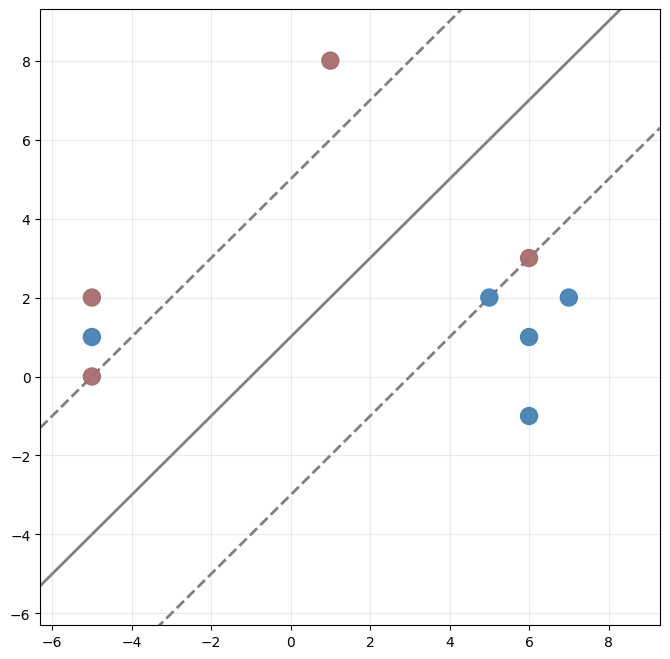

In [15]:
# Data and Labels 
X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,1], [-5,2],[6,3],[6,1],[5,2]])
y = np.array([1,-1,-1,1,-1,1,1,-1,-1])

# Support vector parameters 
w, b = np.array([-1/4, 1/4]), -1/4

# Plot the data and support vector boundaries 
linear_plot(X, y, w=w, b=b)

What is the margin of this particular SVM?

In [4]:
margin = 2*np.sqrt(2)
margin

2.8284271247461903

Which training examples are the support vectors? Assign the coordinate in the list. e.g. support_vectors = [(1,0),(0,0)]

In [5]:
support_vectors = []
for xi in X:
    if abs(w.T@xi+b) == 1:
        support_vectors.append(tuple(xi))

support_vectors

[(-5, 0), (6, 3), (5, 2)]

Which training examples have nonzero slack? List their coordinates.

In [6]:
nonzero_slack=[(-5,1),(6,3)]

Compute the slack $\xi_i$ associated with the misclassified points. 

Slack Formula:
#### ξ<sub>i</sub> = 1 −  y<sub>i</sub> ( w<sup>T</sup> x<sub>i</sub>  + b )

In [7]:
def slack_calculator(xi):
    yi = y[(X == xi).all(axis=1)]
    return (1 - yi * (w.T @ xi +b))[0]

slacks = [slack_calculator(xi) for xi in nonzero_slack]
slack1 = slacks[0]
slack2 = slacks[1]
print(slacks)

[2.25, 2.0]


### The Margin vs Slack 
***
In this problem we'll figure out how to fit linear SVM models to data using sklearn.  Consider the data shown below.

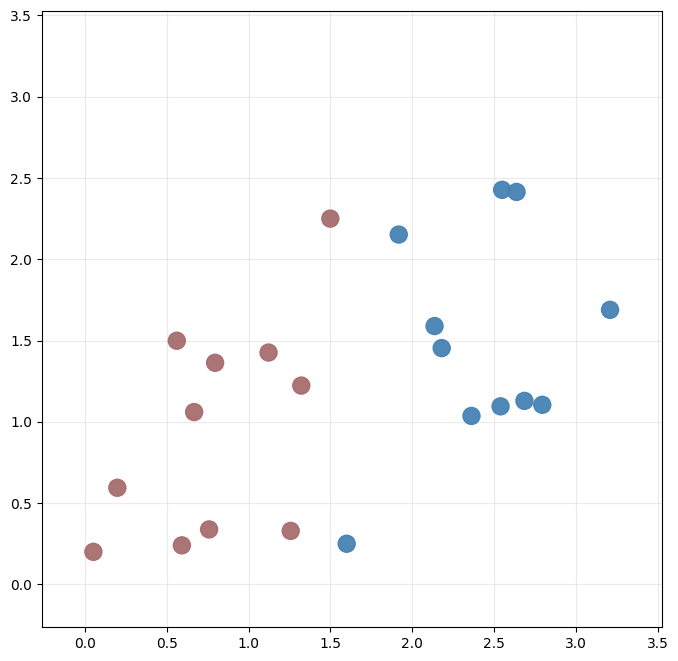

In [16]:
X, y = part2data()
linear_plot(X, y)

Let's fit a linear Soft-Margin SVM to the data above. For SVMs with a linear kernel we'll use the [`LinearSVM`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) method from sklearn's `svm` module.  Go now and look at the documentation. 

Recall that the primal objective function for the linear kernel SVM is as follows 


$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i^p.
$$
**Note that the C parameter definition in sklearn is different from the textbook.**

The two optional parameters in `LinearSVM` that we'll be most concerned with are `C`, the hyperparameter weighting the slackness contribution to the primal objective function, and `loss`, which determines the exponent on the slack variables in the sum. When $p=1$ from above equation, the loss is hinge loss, whereas is $p=2$, it's $L2$ form, the loss is called squared-hinge.

Write some code below to train a linear SVM with $C=1$ and $p=1$, get the computed weight vector and bias, and the plot the resulting model. 

[-1.41897528  0.30584252] [1.76759606]


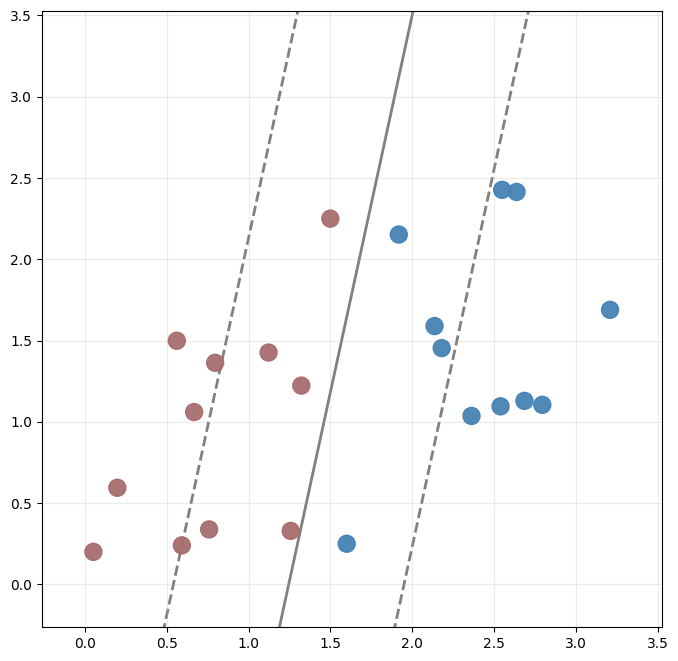

In [22]:
from sklearn.svm import LinearSVC

# TODO: Build a LinearSVC model called lsvm. Train the model and get the parameters, pay attention to the loss parameter
lsvm = LinearSVC(C=1, loss="hinge")
# your code here
lsvm = lsvm.fit(X,y)

# use this code to plot the resulting model
w = lsvm.coef_[0]
b = lsvm.intercept_
print(w,b)
linear_plot(X, y, w=w, b=b)

### Nonlinear SVM, Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ associated with the slack variables in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^d$ you have to select the shift $c$ and the polynomial degree $d$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data


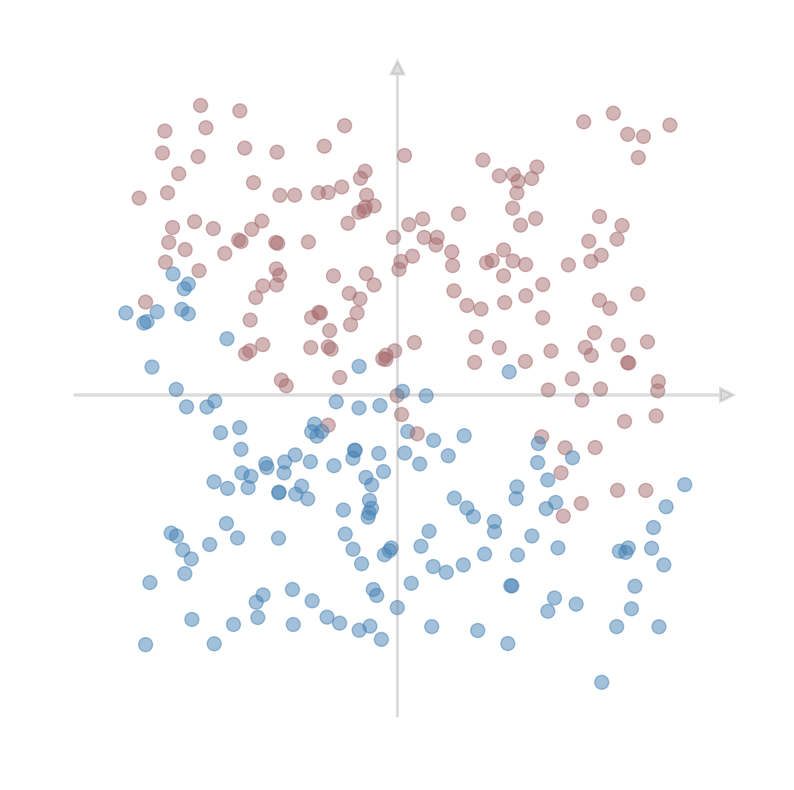

In [10]:
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

We can use the method SVC from sklearn's svm module to fit an SVM with a nonlinear kernel to the data. Go now and look at the documentation. Note that we pass the kernel="rbr" parameter to use the RBF kernel. The other two parameters we'll be concerned with are C and the RBF parameter gamma.

Write some code to fit an SVM with RBF kernel to the data and plot the results. Use the parameter values C=1 and gamma=1.

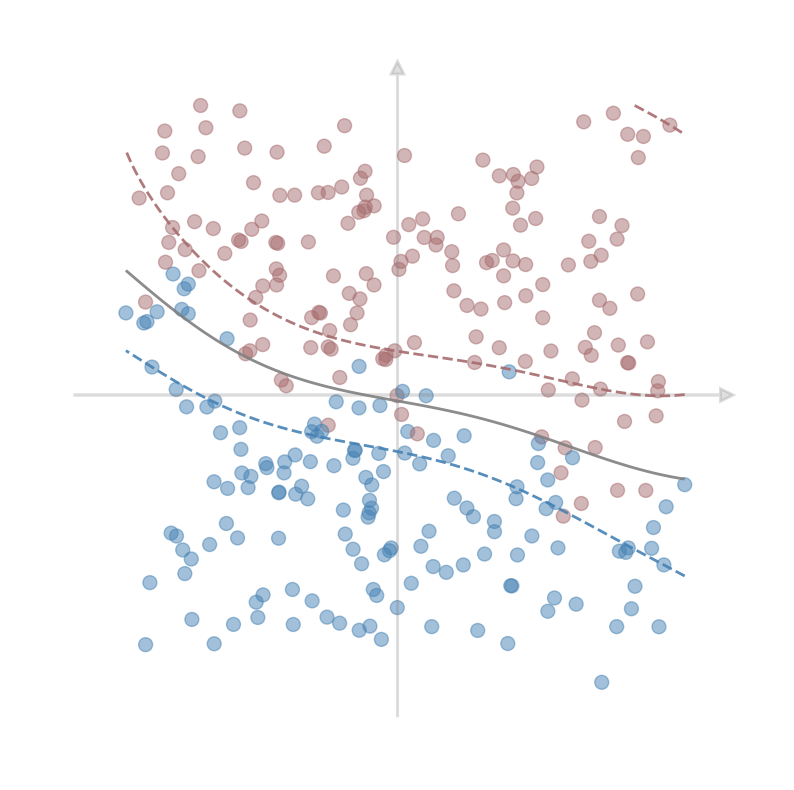

In [11]:
from sklearn.svm import SVC

nlsvm= SVC(kernel="rbf", C=1, gamma=1)
# your code here

nonlinear_plot(X, y, nlsvm)

 In this part we'll use cross-validation to estimate the validation accuracy achieved by our model. Experiment with the values of the hyperparameters to see if you can get a good validation accuracy. How do the choice of C and gamma affect the resulting decision boundary? 

cross-val mean-accuracy: 0.000


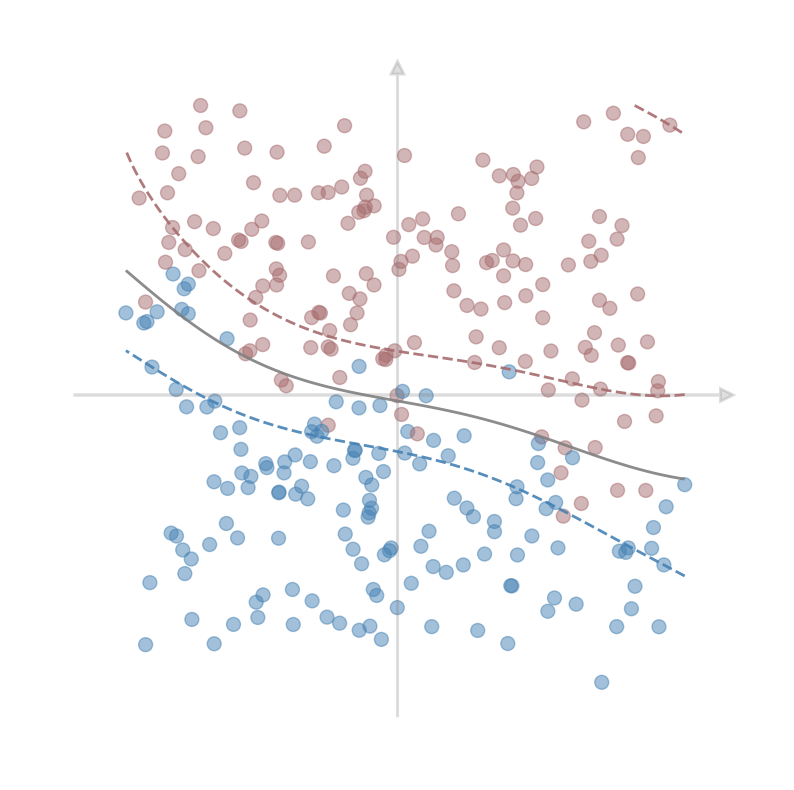

In [12]:
from sklearn.model_selection import cross_val_score

# your code here

# uncomment and update nlsvm and scores
nlsvm 
scores=0
print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
nonlinear_plot(X, y, nlsvm)

# C tuning
# your code here


# gamma tuning
# your code here